In [177]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
import string
from stop_words import get_stop_words

import simplemma
import simpletransformers
from sklearn.model_selection import train_test_split
from simpletransformers.classification import ClassificationModel
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

## Načtení datasetu

In [178]:
dataset = pd.read_csv("./dataset_rss.csv")

## Základní EDA

Ještě před samotnou klasifikační úlohou je vhodné porozumět datům. K tomu nám poslouží základní EDA.

### Dimenze datasetu a shrnutí základních informací

In [179]:
dataset.shape
dataset.info()

# jsou v datasetu duplikované záznamy?
dup = dataset.duplicated()
sum(dup)

# jsou v datasetu chybějící hodnoty?
dataset.isnull().sum()

(45911, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45911 entries, 0 to 45910
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     45911 non-null  object
 1   title   45911 non-null  object
 2   perex   45911 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


0

url      0
title    0
perex    0
dtype: int64

Z výstupu je patrné, že dataset neobsahuje chybějící hodnoty ani duplikované záznamy.

### Zobrazení prvních/posledních pěti záznamů a náhodně vybraných deseti záznamů 

In [180]:
dataset.head()
dataset.tail()
dataset.sample(10)

,url,title,perex
0,https://www.novinky.cz/auto/404533-modernizova...,"Modernizovaný VW Amarok ukázal interiér, v Čes...",Automobilka Volkswagen konečně zveřejnila sním...
1,https://www.novinky.cz/auto/416704-audi-r8-v10...,"Audi R8 V10 Plus: Podívejte se, s jakou lehkos...",Na několik dní se v naší redakční garáži objev...
2,https://www.novinky.cz/auto/429367-toyota-uz-p...,Toyota už prodala deset miliónů hybridů,"Na světě není značka, která by mohla říct, že ..."
3,https://www.novinky.cz/auto/430723-ridit-auto-...,Řídit auto z pohodlí obýváku? Díky 5G sítím to...,"Zní to jako sci-fi, ale představte si, že vaše..."
4,https://www.novinky.cz/auto/434065-novy-renaul...,Nový Renault Mégane R.S. dostane menší motor,Nový nejrychlejší Renault Mégane R.S. bude mít...


,url,title,perex
45906,http://www.novinky.cz/zena/zdravi/397057-pet-b...,Pět bylin na pročištění těla,"Zbavovat tělo škodlivých látek můžete kdykoli,..."
45907,http://www.novinky.cz/zena/zdravi/397264-pust-...,Půst není o hladovění,S přicházejícím jarem nastává období očisty or...
45908,http://pravo.novinky.cz/p101a05a.php,Krúpa by na dluh ČSSD počkal i roky,Skupina Arca Capital slovenského miliardáře Pa...
45909,http://pravo.novinky.cz/p125a04b.php,Mlha kolem StarDance,Ke konci roku začne Česká televize (ČT) vysíla...
45910,http://pravo.novinky.cz/p145a01e.php,"Matka, bojující za byt pro svého autistického ...","Helena (55) trpící rakovinou, která se starala..."


,url,title,perex
23782,https://www.novinky.cz/vase-zpravy/jihomoravsk...,Autorské čtení Jaroslava Hutky na kunštátském ...,"Hudebník, skladatel, písničkář, fejetonista Ja..."
14979,https://www.novinky.cz/vase-zpravy/stredocesky...,MMA zápasnice Lucie Pudilová odletěla do Švéds...,Nejdrsnější MMA zápasnice Lucie Pudilová se po...
42483,https://www.novinky.cz/vase-zpravy/ustecky-kra...,Střekovský festival Mezi Dvorci již po šesté,Na Střekově se v sobotu uskuteční festival Mez...
41702,https://www.novinky.cz/auto/428858-skoda-poprv...,"Škoda poprvé ukázala omlazené citigo, natáhlo ...","Škoda vytasila svůj patrně poslední model, kte..."
33323,http://www.novinky.cz/auto/401229-volkswagen-v...,Volkswagen vylepší další užitkové vozy. Dojde ...,Zatímco většina konkurentů mění své vozy po ně...
39211,https://www.novinky.cz/vase-zpravy/vysocina/ji...,Jana Kratochvílová odstartuje turné na zámku v...,Podzimní turné nezaměnitelné zpěvačky Jany Kra...
35165,https://www.novinky.cz/zahranicni/evropa/44541...,V Německu a Nizozemsku přibývá lidí se zahrani...,V Německu nadále stoupá počet lidí s migračním...
32153,https://www.novinky.cz/vase-zpravy/jihomoravsk...,Do Mikulova na folklorní festival Sousedé doje...,Folklorní festival Sousedé se bude letos v Mik...
5508,http://www.novinky.cz/zahranicni/evropa/385717...,Putinova exporadce našli mrtvého v americkém h...,V hotelu Dupont Circle ve Washingtonu byl nale...
1593,https://www.novinky.cz/mff-kv-2016/408505-nocn...,Noční život je o strachu v dnešní Evropě a moc...,Režisér a scenárista Damjan Kozole s herečkou ...


## Předzpracování datasetu 

Pro účely provedení supervizované klasifikační úlohy je nutné určit každému záznamu *label*, tj. třídu cílového atributu.

In [181]:
dataset['label'] = dataset['url'].str.extract('.cz/(.+?)/')

### Kontrola nového atributu

In [182]:
dataset.head()
dataset.tail()

dataset.isna().sum()

,url,title,perex,label
0,https://www.novinky.cz/auto/404533-modernizova...,"Modernizovaný VW Amarok ukázal interiér, v Čes...",Automobilka Volkswagen konečně zveřejnila sním...,auto
1,https://www.novinky.cz/auto/416704-audi-r8-v10...,"Audi R8 V10 Plus: Podívejte se, s jakou lehkos...",Na několik dní se v naší redakční garáži objev...,auto
2,https://www.novinky.cz/auto/429367-toyota-uz-p...,Toyota už prodala deset miliónů hybridů,"Na světě není značka, která by mohla říct, že ...",auto
3,https://www.novinky.cz/auto/430723-ridit-auto-...,Řídit auto z pohodlí obýváku? Díky 5G sítím to...,"Zní to jako sci-fi, ale představte si, že vaše...",auto
4,https://www.novinky.cz/auto/434065-novy-renaul...,Nový Renault Mégane R.S. dostane menší motor,Nový nejrychlejší Renault Mégane R.S. bude mít...,auto


,url,title,perex,label
45906,http://www.novinky.cz/zena/zdravi/397057-pet-b...,Pět bylin na pročištění těla,"Zbavovat tělo škodlivých látek můžete kdykoli,...",zena
45907,http://www.novinky.cz/zena/zdravi/397264-pust-...,Půst není o hladovění,S přicházejícím jarem nastává období očisty or...,zena
45908,http://pravo.novinky.cz/p101a05a.php,Krúpa by na dluh ČSSD počkal i roky,Skupina Arca Capital slovenského miliardáře Pa...,NaN
45909,http://pravo.novinky.cz/p125a04b.php,Mlha kolem StarDance,Ke konci roku začne Česká televize (ČT) vysíla...,NaN
45910,http://pravo.novinky.cz/p145a01e.php,"Matka, bojující za byt pro svého autistického ...","Helena (55) trpící rakovinou, která se starala...",NaN


url        0
title      0
perex      0
label    176
dtype: int64

Nově vytvořený atribut *label* nabývá ve 176 případech nulové/chybějící hodnoty. Podíváme se tedy na to podrobněji.

In [183]:
dataset[dataset.isna().any(axis=1)]

,url,title,perex,label
459,http://pravo.novinky.cz/p138a19e.php,Bolt má formu zpátky,PRAHA – O jednu olympijskou medaili zřejmě při...,NaN
928,http://pravo.novinky.cz/p142a16f.php,V Kosovu obviněny kvůli korupci desítky lékařů...,Čtyřiašedesát lidí včetně ministra životního p...,NaN
1382,http://pravo.novinky.cz/p115a02b.php,ZAČALY ÚSTNÍ MATURITY.,Na středních školách začaly včera ústní části ...,NaN
1383,http://pravo.novinky.cz/p121m10h.php,Krátce,* V BRNĚ-LÍŠNI kulminuje napětí kolem budoucno...,NaN
1384,http://pravo.novinky.cz/p151a01e.php,"Jste silná individualita, dostal stopku oceňov...",Že ani úspěchy z minulosti nejsou zárukou do b...,NaN
...,...,...,...,...
44971,http://pravo.novinky.cz/p101a03a.php,"Státní přijímačky? Každá druhá úloha špatně, ž...",Státní přijímačky na střední školy poukázaly n...,NaN
45428,http://pravo.novinky.cz/p143a04a.php,"My to Euro stejně vyhrajem, bouřily Žluté lázně","Když se zdálo, že z pražských Žlutých lázní za...",NaN
45908,http://pravo.novinky.cz/p101a05a.php,Krúpa by na dluh ČSSD počkal i roky,Skupina Arca Capital slovenského miliardáře Pa...,NaN
45909,http://pravo.novinky.cz/p125a04b.php,Mlha kolem StarDance,Ke konci roku začne Česká televize (ČT) vysíla...,NaN


Atribut *label* nabývá nulové hodnoty v případech, kdy se struktura URL liší od vzoru uvedeného v příslušném regulárním výrazu. Z URL typu http://pravo.novinky.cz/p101a05a.php nelze *label* odvodit, a tak nám nezbývá než záznamy s chybějící hodnotou ve sloupci *label* z datasetu odstranit.

#### Odstranění záznamů s chybějící hodnotou nového atributu

In [184]:
dataset.isna().sum()
dataset.shape
dataset = dataset.dropna()
dataset.isna().sum()
dataset.shape

url        0
title      0
perex      0
label    176
dtype: int64

(45911, 4)

url      0
title    0
perex    0
label    0
dtype: int64

(45735, 4)

#### Kontrola tříd cílového atributu

Nyní se blíže podíváme na kategorie cílového atributu *label*. Zajímají nás zejména četnosti jednotlivých kategorií/tříd.

In [185]:
dataset.groupby(['label']).size()
dataset.groupby(['label']).size().shape

label
2009                    1
2014                    1
auto                 1093
bydleni               794
cestovani            1358
domaci               5378
ekonomika            2312
finance               286
horoskop              290
internet-a-pc        1303
irak                    4
kariera               365
koktejl              1244
komentare             359
komercni-clanky       157
krimi                4077
kultura              3601
mff-kv-2016            81
mff-kv-2017            71
muzi                  256
specialy               22
stalo-se               54
vanoce                107
vase-zpravy         12665
veda-skoly            863
volba_prezidenta        1
zahranicni           7788
zena                 1203
zika                    1
dtype: int64

(29,)

Atribut *label* má 29 tříd. Třídy s četností jedna jsou v rámci klasifikační úlohy nepoužitelné. Proto záznamy, jejichž hodnota atributu label nabývá třídy, která se vyskytuje v datasetu jen jednou, odstraníme. Jinými slovy odstraníme záznamy s unikátní hodnotou atributu label.

In [186]:
dataset = dataset.groupby('label').filter(lambda x : len(x)>1)

dataset.groupby(['label']).size()
dataset.groupby(['label']).size().shape

label
auto                1093
bydleni              794
cestovani           1358
domaci              5378
ekonomika           2312
finance              286
horoskop             290
internet-a-pc       1303
irak                   4
kariera              365
koktejl             1244
komentare            359
komercni-clanky      157
krimi               4077
kultura             3601
mff-kv-2016           81
mff-kv-2017           71
muzi                 256
specialy              22
stalo-se              54
vanoce               107
vase-zpravy        12665
veda-skoly           863
zahranicni          7788
zena                1203
dtype: int64

(25,)

Zbyde nám tedy 25 kategorií/tříd cílového atributu. Je patrné, že dataset je z hlediska distribuce tříd cílového atributu nevyrovnaný. Tuto skutečnost musíme brát v potaz při testování predikčních schopností natrénovaného modelu. 

### Předzpracování textu

Pokud v rámci analýzy/klasifikační úlohy pracujeme s texty v přirozeném jazyce, pak je v dobré tyto texty podrobit předzpracování/čištění za použití technik NLP. Použitím tím příslušných technik se nám podaří transformovat texty konzistentní podoby. Pro tento účel dochází nad textovým atributem *title* k:

* lowercase transformaci,
* odstranění textů v závorkách, interpunkce,
* odstranění linků, čísel a slov obsahující čísla,
* odstranění bezvýznamových stop slov.

Pro tento účel dochází k definování dvou následujících funkcí:

In [187]:
stop_words = get_stop_words('cz')

def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


def text_preprocessing(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    remove_stopwords = [w for w in tokenized_text if w not in stop_words]
    combined_text = ' '.join(remove_stopwords)
    return combined_text

Provedení předzpracování nad atributem *title*:

In [188]:
dataset['title_clean'] = dataset['title'].apply(str).apply(lambda x: text_preprocessing(x))

dataset[['title', 'title_clean']].head()
dataset[['title', 'title_clean']].tail()

,title,title_clean
0,"Modernizovaný VW Amarok ukázal interiér, v Čes...",modernizovaný vw amarok ukázal interiér v česk...
1,"Audi R8 V10 Plus: Podívejte se, s jakou lehkos...",audi plus podívejte s jakou lehkostí dostane kmh
2,Toyota už prodala deset miliónů hybridů,toyota prodala miliónů hybridů
3,Řídit auto z pohodlí obýváku? Díky 5G sítím to...,řídit auto z pohodlí obýváku díky sítím půjde
4,Nový Renault Mégane R.S. dostane menší motor,nový renault mégane rs dostane menší motor


,title,title_clean
45903,Kalhotová sukně se nosí i na podzim,kalhotová sukně nosí i podzim
45904,Dcera monackého knížete chce jít ve šlépějích ...,dcera monackého knížete jít šlépějích své babi...
45905,Nastal měsíc mužské solidarity,nastal měsíc mužské solidarity
45906,Pět bylin na pročištění těla,bylin pročištění těla
45907,Půst není o hladovění,půst o hladovění


### Transformace cílové proměnné na numerickou proměnnou a rozdělení datasetu na trénovací a testovací část

Některé metody strojového učení předpokládají, že cílový atribut nabývá numerických hodnot. Z toho důvodu je rozumné přistoupit k následující transformaci:

In [189]:
le = LabelEncoder()
dataset['label'] = le.fit_transform(dataset['label'])

dataset.groupby(['label']).size()

label
0      1093
1       794
2      1358
3      5378
4      2312
5       286
6       290
7      1303
8         4
9       365
10     1244
11      359
12      157
13     4077
14     3601
15       81
16       71
17      256
18       22
19       54
20      107
21    12665
22      863
23     7788
24     1203
dtype: int64

Posledním krokem před samotnou klasifikační úlohou, resp. modelováním je rozdělení datasetu na trénovací a testovací část v poměru 8:2 při respektování distribuce tříd v celkovém datasetu. O to se stará parametr *stratify*. 

In [190]:
train, test = train_test_split(dataset[['title_clean', 'label']],
                                                    test_size=.2, random_state=123,
                                                    stratify=dataset['label'])
 
print('train shape: ',train.shape)
print('test shape: ',test.shape)

train shape:  (36584, 2)
test shape:  (9147, 2)


## Modelování 

Předzpracovaný dataset lze nyní použít ve fázi modelování. Cílem modelování je za použití trénovací sady dat natrénovat klasifikační model vybrané metody strojového učení. V kontextu klasifikační úlohy nad přirozenými texty je možné se vydat dvěma směry: 

* tradiční: založený na modelech *TF-IDF* transformující texty na jejich vektorovou reprezentaci a na následném použití modelů klasifikačních metod ML nad těmito reprezentacemi,
* moderní: založený nad metodě *DNN*, tj. hlubokých neuronových sítí, které provádějí embedding a klasifikaci v rámci jednoho supervizovaného modelu.

Pro účely tohoto úkolu je vybrán přístup druhý. Abychom nemuseli přistupovat k trénování celého modelu s vlastní architekturou, lze pro účely této úlohy přepoužít nějaký volně dostupný a na rozsáhlých datech předtrénovaný model a dotrénovat ho na našich datech. Vzhledem ke skutečnosti, že se jedná o úlohu nad texty v češtině, máme na výběr ze dvou skupin předtrénovaných modelů:

* Multilingvální modely (mBERT,...),
* Monolingvální modely pro češtinu (Czert-B-base-cased,...).

Multilingvální modely bývají větší, komplexnější (více parametrů), vyžadují více dat a více výpočnch zdrojů pro jejich přetrénování. Z toho důvodu vybereme monolingvální model *Czert-B-base-cased* (https://huggingface.co/UWB-AIR/Czert-B-base-cased
), který umí pracovat s češtinou. 

Samotné modelování využívá funkcionalitu knihovny *Simple Transformers*. https://simpletransformers.ai/docs/usage/

### Načtení předtrénovaného modelu a definování parametrů pro trénování 

In [147]:
# define hyperparameter
train_args ={'num_train_epochs': 3,
            'train_batch_size': 32,
            'eval_batch_size': 64,
            'fp16': False,
            "reprocess_input_data": True,
            'overwrite_output_dir': True}
 
# Create a ClassificationModel
model = ClassificationModel("bert", "UWB-AIR/Czert-B-base-cased",
                            num_labels=25,
                            args=train_args,
                            use_cuda=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UWB-AIR/Czert-B-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Trénování modelu

U předtrénovaného modelu dochází za použití doménově specifických trénovacích dat k přetrénování jeho klasifikační části. 

In [148]:
model.train_model(train)

C:\Users\jveverka\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:585: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


(3432, 0.6182293110556406)

### Evaluace modelu 

U dotrénovaného modelu nyní přistoupíme k otestovaní jeho predikčních/klasifikačních schopností na připravené testovací sadě dat. Jako základní evaluační metriku zvolíme *celkovou správnost klasifikace* (Accuracy).

In [153]:
result, model_outputs, wrong_predictions = model.eval_model(test, acc=sklearn.metrics.accuracy_score)
result

{'mcc': 0.777862194336891,
 'acc': 0.8096643708319667,
 'eval_loss': 0.7059078866785223}

Z výše uvedeného výstupu je patrné, že hodnota metriky *celkové správnosti* na testovacích datech přesahuje 80 procent, tj. přibližně každý pátý testovací záznam byl klasifikován do jiné než jeho skutečné třídy. 

#### Matice záměn 
Hodnota metriky *celková správnost* nemusí být vždy reprezentativním ukazatelem kvality modelu. Z toho důvodu je vhodné si zobrazit *matici záměn* (confusion matrix), která dává do souvislosti v kontextu jednotlivých tříd predikované a skutečné třídy. Dají se pak z ní dopočítat ostatní metriky typu *přesnost, úplnost, F1 míra,...*

Určení predikovaných a skutečných tříd a následná kontrola hodnoty testovací *celkové správnosti*:

In [191]:
predicted_classes = [np.argmax(arr) for arr in model_outputs]
true_classes = test['label'].tolist()

accuracy_score(true_classes, predicted_classes)

0.8096643708319667

Pro zobrazení *matice záměn* využijeme pomocnou funkci:

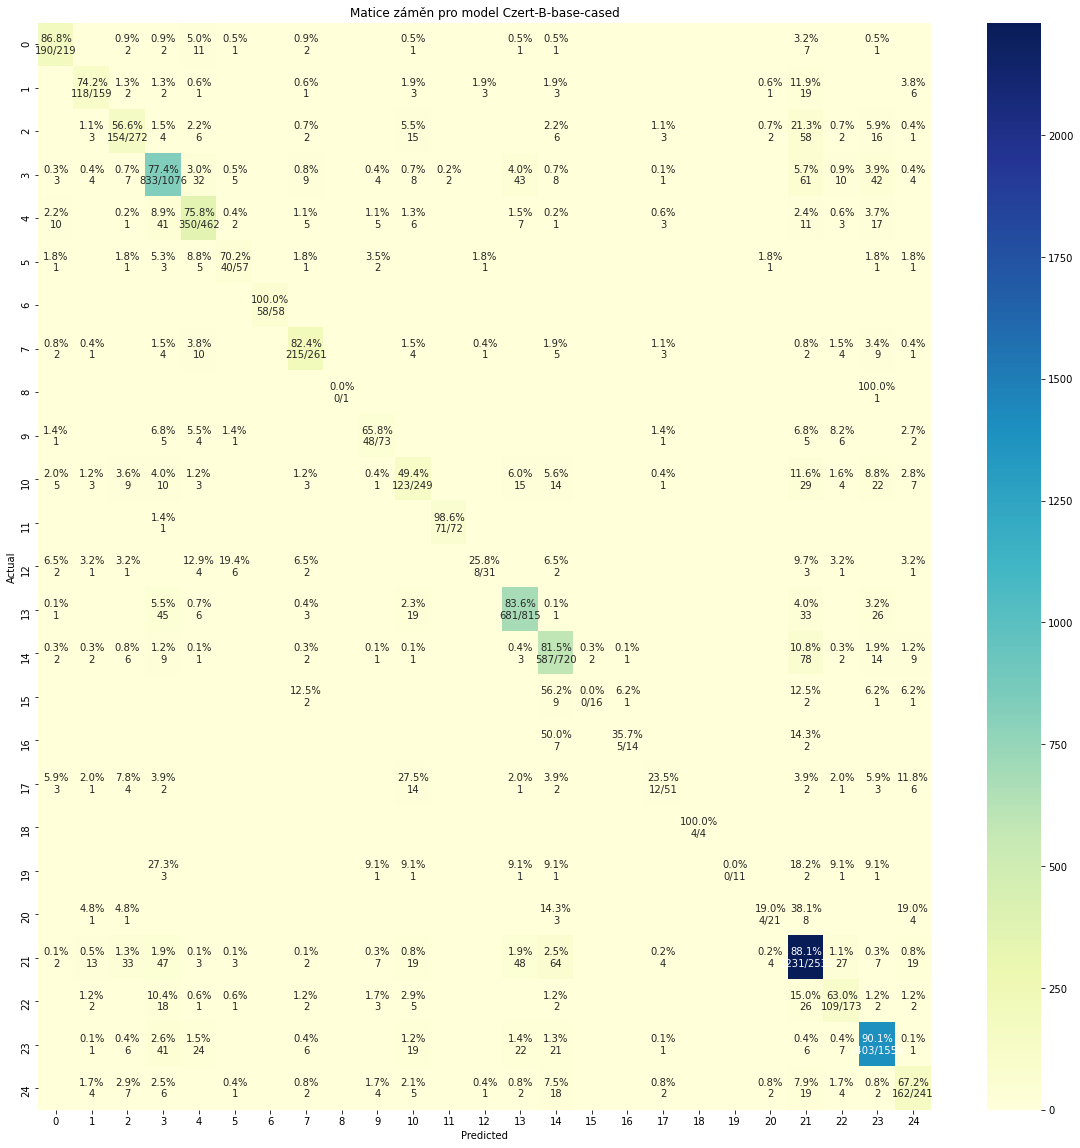

In [192]:
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    
    
plot_cm(true_classes, predicted_classes, 'Matice záměn pro model Czert-B-base-cased', figsize=(20,20))

Interpretace *matice záměn* je následující: Pokud vezmeme v potaz buňku na pozici 1x1, tak ta nám říká, že z celkového počtu testovacích záznamů nabývající třídy 1 (159), bylo 74procentům těchto záznamů také tato třída modelem predikována. Této hodnotě se standardně říká *úplnost*. Ta se vypočítá vůči každé třídě a udává, jakému podílu testovacích záznamů s danou třídou byla modelem také tato třída predikována. Na podobném principu funguje i metrika *přesnost*. Ta v kontextu každé třídy udává v kolika procentech případů, kdy model predikoval onu třídu, predikovat tuto třídu správně.